# Clustering

Using clustering, we may be able to find particular clusters of patients that have a higher amount of Alzheimer's disease than others. Then, based on the differences between clusters, we might be able to find a pattern.

In [19]:
import data_reader
import numpy as np
from scipy.stats import mode


def dissimilarity_score(v1, v2):
    # Calculate the amount of differences between categorical features
    return np.sum(v1 != v2)


def euclidian_distance(v1, v2):
    # Calculate the euclidian distance between numerical features
    return np.sqrt(np.sum((v1 - v2)**2))


def assign_cluster(prototypes, clusters, point):
    dissimilarities = []
    for pt in prototypes:
        v_n = num_matrix[point]
        v_c = cat_matrix[point]
        pt_v_n = pt[0]
        pt_v_c = pt[1]
        dissimilarity = dissimilarity_score(
            pt_v_n, v_n) + euclidian_distance(pt_v_c, v_c)
        dissimilarities.append(dissimilarity)

    dissimilarities = np.array(dissimilarities)
    cluster = np.where(dissimilarities == dissimilarities.min())[0][0]
    clusters[cluster].append((num_matrix[point], cat_matrix[point]))

    return clusters


def calc_prototype(cluster, init_index):
    # Calculate a new prototype
    if len(cluster) == 0:
        return (num_matrix[init_index], cat_matrix[init_index])
    num_cluster = np.vstack([point[0] for point in cluster])
    num_prototype = np.mean(num_cluster, axis=0)
    cat_cluster = np.vstack([point[1] for point in cluster])
    cat_prototype = mode(cat_cluster, axis=0).mode

    return (num_prototype, cat_prototype)


def k_prototypes_clustering(num_matrix, cat_matrix, k, verbose=False, initial_prototypes=None):
    if initial_prototypes is None:
        # Randomly select k initial prototypes
        prototypes_indices = np.random.randint(0, len(num_matrix), k)
        init_indexes = prototypes_indices.copy()
        if verbose:
            print(f'Selected initial prototypes indices: {prototypes_indices}')

        # Initialize prototypes as a list of tuples with numeric and categorical data
        prototypes = [(num_matrix[i], cat_matrix[i])
                      for i in prototypes_indices]
    else:
        init_indexes = initial_prototypes.copy()
        if len(initial_prototypes) != k:
            raise ValueError("The number of initial prototypes must match k.")
        prototypes = [(num_matrix[i], cat_matrix[i])
                      for i in initial_prototypes]

    clusters = [[] for _ in range(k)]

    while True:
        # Assign each data point to the nearest prototype cluster
        for i in range(len(num_matrix)):
            clusters = assign_cluster(prototypes, clusters, i)

        # Calculate new prototypes for each cluster
        new_prototypes = [calc_prototype(clusters[i], init_indexes[i]) for i in range(len(clusters))]

        # Check for convergence
        done = True
        for i in range(len(prototypes)):
            if not np.array_equal(prototypes[i][0], new_prototypes[i][0]) or \
               not np.array_equal(prototypes[i][1], new_prototypes[i][1]):
                done = False
                break

        if done:
            break

        # Update prototypes and reset clusters for the next iteration
        prototypes = new_prototypes
        clusters = [[] for _ in range(k)]

    if verbose:
        print(f'--- {k} clusters found ---')
        for i, cluster in enumerate(clusters):
            print(f' - Cluster {i + 1} with size={len(cluster)}')

    return clusters, prototypes, prototypes_indices


data = data_reader.get_data_dict('./data/alzheimers_disease_data.csv')

# Numerical columns
num_cols = ['BMI', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL',
            'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment',
            'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality',
            'ADL']
# Categorical columns
cat_cols = ['FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes',
            'Depression', 'Hypertension', 'MemoryComplaints', 'BehavioralProblems',
            'Confusion', 'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks',
            'Forgetfulness', 'HeadInjury', 'Smoking', 'Ethnicity', 'Gender',
            'EducationLevel', 'Diagnosis']

num_matrix = np.vstack(tuple(data[col] for col in num_cols)).T
cat_matrix = np.vstack(tuple(data[col] for col in cat_cols)).T

clusters, prototypes, _ = k_prototypes_clustering(num_matrix, cat_matrix, 5, True)

Selected initial prototypes indices: [ 544 2053 1919  824  724]
--- 5 clusters found ---
 - Cluster 1 with size=381
 - Cluster 2 with size=805
 - Cluster 3 with size=281
 - Cluster 4 with size=160
 - Cluster 5 with size=522


In [27]:
num_runs = 50
k = 4

best_clusters = None
best_prototypes = None
best_score = float('inf')
best_prototype_index = None

# Perform multiple runs to find which initial prototypes produce the smallest
# total difference
for run in range(num_runs):
    clusters = [[] for _ in range(k)]

    clusters, prototypes, prototype_index = k_prototypes_clustering(num_matrix, cat_matrix, k)

    # Evaluate within-cluster distance
    total_distance = 0
    for cluster_idx, cluster in enumerate(clusters):
        for point in cluster:
            num_distance = euclidian_distance(point[0], prototypes[cluster_idx][0])
            cat_distance = dissimilarity_score(point[1], prototypes[cluster_idx][1])
            total_distance += num_distance + cat_distance

    # Update the best solution if this run is better
    if total_distance < best_score:
        best_score = total_distance
        best_clusters = clusters
        best_prototypes = prototypes
        best_prototype_index = prototype_index

# Print the best clustering result
print(f"Best clustering result found after {num_runs} runs:")
print(f"Within-cluster distance: {best_score:.2f}")
for i, cluster in enumerate(best_clusters):
    print(f"Cluster {i + 1}: {len(cluster)} points")


Best clustering result found after 50 runs:
Within-cluster distance: 264597.17
Cluster 1: 646 points
Cluster 2: 667 points
Cluster 3: 80 points
Cluster 4: 756 points


In [21]:
print(best_prototype_index)

[ 490  494 1794  853]


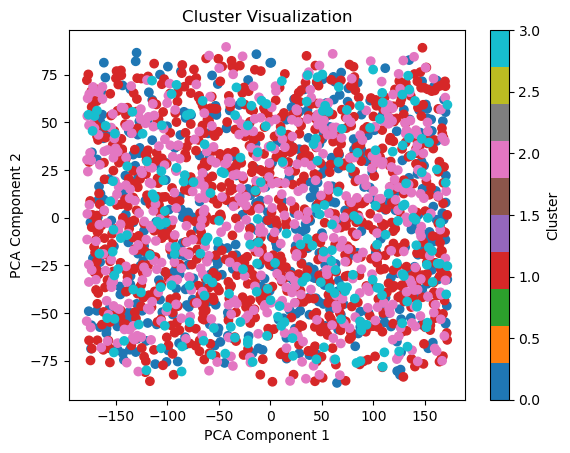

In [22]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
cluster_data = [point[0] for cluster in best_clusters for point in cluster]
cluster_labels = [i for i, cluster in enumerate(best_clusters) for _ in cluster]

reduced_data = pca.fit_transform(cluster_data)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='tab10')
plt.title("Cluster Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()


In [23]:
# Reproduce results
# Initialize prototypes using the best starting indices
prototypes = best_prototype_index
prototypes = [1058,  598,   42, 1106, 1647]
prototypes = [(num_matrix[i], cat_matrix[i]) for i in prototypes]

# Run the k-prototypes algorithm once with these prototypes to reproduce the result
clusters, prototypes, prototype_index = k_prototypes_clustering(num_matrix, cat_matrix, k)

print("Reproduced clustering result:")
for i, cluster in enumerate(clusters):
    print(f"Cluster {i + 1}: {len(cluster)} points")


Reproduced clustering result:
Cluster 1: 681 points
Cluster 2: 497 points
Cluster 3: 576 points
Cluster 4: 395 points


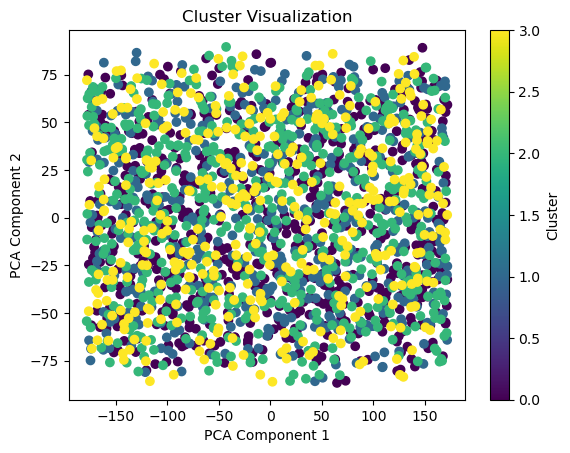

In [24]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
cluster_data = [point[0] for cluster in clusters for point in cluster]
cluster_labels = [i for i, cluster in enumerate(clusters) for _ in cluster]

reduced_data = pca.fit_transform(cluster_data)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels)
plt.title("Cluster Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()

In [26]:
means = []
modes = []
ratios = []
for cluster in clusters:
    cluster_num_matrix = np.array([item[0] for item in cluster])
    cluster_cat_matrix = np.array([item[1] for item in cluster])
    diagnosis = cluster_cat_matrix[:, -1]
    count_zeros = np.sum(diagnosis == 0)
    count_ones = np.sum(diagnosis == 1)
    ratios.append(count_ones/(count_zeros + count_ones))
    cluster_means = np.mean(cluster_num_matrix, axis=0)
    cluster_modes = mode(cluster_cat_matrix, axis=0).mode
    means.append(cluster_means)
    modes.append(cluster_modes)


print('-- Ratios of diagnosis --')
print(ratios)

print('-- Numerical Columns means --')
for i in range(len(num_cols)):
    print(num_cols[i])
    print([mean[i] for mean in means])

print('-- Categorical Columns modes --')
for i in range(len(cat_cols)):
    print(cat_cols[i])
    print([mode[i] for mode in modes])


-- Ratios of diagnosis --
[0.7004405286343612, 0.12877263581488935, 0.19618055555555555, 0.2683544303797468]
-- Numerical Columns means --
BMI
[27.92429711712828, 27.905274152264177, 27.402491538858737, 27.247822629204105]
SystolicBP
[133.94566813509545, 135.48893360160966, 133.79166666666666, 133.9645569620253]
DiastolicBP
[90.02496328928046, 89.40442655935614, 89.97916666666667, 89.90886075949368]
CholesterolTotal
[225.91706816413026, 226.88897685755572, 224.9397777049612, 222.20458529799612]
CholesterolLDL
[121.94930188606648, 123.20469627400813, 125.9881772705413, 127.46467124555453]
CholesterolHDL
[60.51451147754612, 60.36708212661929, 59.21038700125689, 56.8838675304017]
CholesterolTriglycerides
[231.8659040903932, 231.4852400698255, 223.03955514259175, 225.71470006300402]
MMSE
[13.084994363655827, 15.84004755187571, 14.981761652571372, 15.9389851000414]
FunctionalAssessment
[4.219369965232148, 5.55248370435339, 5.422753068932313, 5.46976460242251]
AlcoholConsumption
[10.15299529